In [9]:
# entire code is being run on an Ubuntu kernel. 
# not many QoL libraries are needed.
# your mileage may vary.
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# dataset imports
import utils_ade20k
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Resize, ToPILImage, Lambda
import torchvision.transforms as transforms

# AI imports
from torch.nn import ConvTranspose2d, Conv2d, MaxPool2d, Module, ModuleList, ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch.nn as nn
import torch

# statistics
from torchinfo import summary
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, roc_curve

# test if GPU acceleration is working
torch.cuda.is_available()

True

## This notebook will be used for creating the segmentation model based on the ADE20K dataset.

### Step 1. EDA

In [2]:
# load in the ade20k pickle file to examine it.
root = './ade20k/ADEChallengeData2016/'
images_dir = f"{root}/images"
annotations_dir = f"{root}/annotations"
# with open(root + 'index_ade20k.pkl', 'rb') as f:
#     index_ade20k = pickle.load(f)

In [3]:
images_training_dir = f"{images_dir}/training"
annotations_training_dir =  f"{annotations_dir}/training"

images_validation_dir = f"{images_dir}/validation"
annotations_validation_dir = f"{annotations_dir}/validation"

training_images = sorted(os.listdir(images_training_dir))
print(len(training_images))

training_annotations = sorted(os.listdir(annotations_training_dir))
print(len(training_annotations))

20210
20210


In [4]:
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class ADE20KDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(annotations_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        
        img_name = os.path.join(self.images_dir, image_filename)
        image = Image.open(img_name).convert("RGB")
        
        # Generate the mask filename based on the image filename
        mask_filename = image_filename.replace(".jpg", ".png")
        mask_name = os.path.join(self.annotations_dir, mask_filename)

        mask = Image.open(mask_name)

        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)

        return image, mask

DETOUR 1: Find a good size to scale all images to for all models moving forward

In [37]:
img_h, img_w = np.zeros((len(training_images))), np.zeros((len(training_images)))
for idx in range(len(training_images)):
    timg = read_image(images_training_dir + '/' + training_images[idx])
    img_h[idx] = timg.shape[1]
    img_w[idx] = timg.shape[2]

In [39]:
image_size = pd.DataFrame({'H': img_h, 'W': img_w}, dtype='int')
image_size.describe()

,H,W
count,20210.000000,20210.000000
mean,416.506977,515.995596
std,140.095244,194.645060
min,96.000000,130.000000
25%,256.000000,300.000000
50%,480.000000,512.000000
75%,512.000000,683.000000
max,2100.000000,2100.000000


In [43]:
image_size['ratio'] = image_size['H'] / image_size['W']

In [44]:
image_size.mode()

,H,W,ratio
0,512,683,0.749634


array([[<Axes: title={'center': 'H'}>, <Axes: title={'center': 'W'}>],
       [<Axes: title={'center': 'ratio'}>, <Axes: >]], dtype=object)

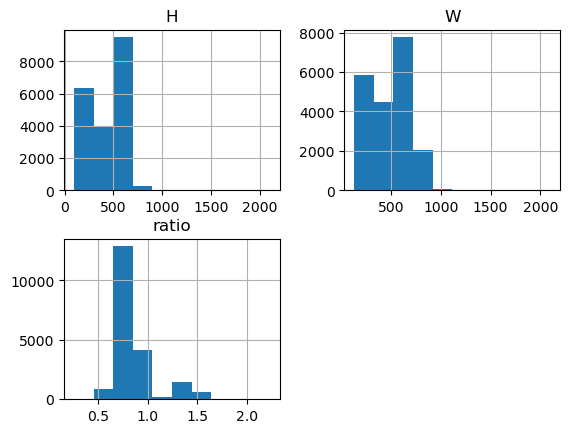

In [46]:
image_size.hist()

/DETOUR 1

In [12]:
train_batch = 96
test_batch = 64

transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    # add padding thing here based on the largest image ig
    transforms.ToTensor()
])

def irregular_image_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return torch.tensor([data, target])

In [13]:
train_dataset = ADE20KDataset(images_training_dir, annotations_training_dir, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = ADE20KDataset(images_validation_dir, annotations_validation_dir, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [32]:
def visualize_image_mask(image, mask):
    plt.subplot(1,2,1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image.permute(1, 2, 0)) # for visualization we have to transpose back to HWC
    plt.subplot(1,2,2)
    # Turn off tick labels
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask.permute(1, 2, 0))  # for visualization we have to remove 3rd dimension of mask
    plt.show()

In [33]:
image = train_dataset[0][0]
mask = train_dataset[0][1]

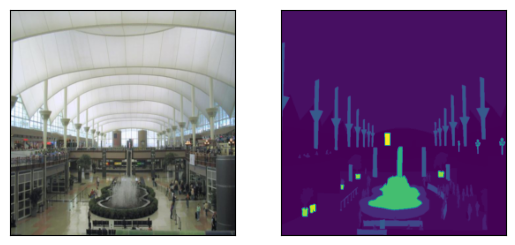

In [34]:
visualize_image_mask(image, mask)

### Everything is in order, time to build the model and train it!

In [17]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [18]:
# initialise hyperparameters

In [19]:
model = UNet(n_channels=3, n_classes=150).float()
if torch.cuda.is_available():
    model.cuda()

In [20]:
summary(model, input_size=(1, 3, 512, 512))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 150, 512, 512]        --
├─inconv: 1-1                                 [1, 64, 512, 512]         --
│    └─double_conv: 2-1                       [1, 64, 512, 512]         --
│    │    └─Sequential: 3-1                   [1, 64, 512, 512]         38,976
├─down: 1-2                                   [1, 128, 256, 256]        --
│    └─Sequential: 2-2                        [1, 128, 256, 256]        --
│    │    └─MaxPool2d: 3-2                    [1, 64, 256, 256]         --
│    │    └─double_conv: 3-3                  [1, 128, 256, 256]        221,952
├─down: 1-3                                   [1, 256, 128, 128]        --
│    └─Sequential: 2-3                        [1, 256, 128, 128]        --
│    │    └─MaxPool2d: 3-4                    [1, 128, 128, 128]        --
│    │    └─double_conv: 3-5                  [1, 256, 128, 128]        886,272
├─down